In [1]:
from functions import *
main_py_libraries_import()
import matplotlib.pyplot as plt
%matplotlib inline
#import pycaret
# Graphical packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# machine learing packages
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn import preprocessing, linear_model
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector 
from yellowbrick.regressor import prediction_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import ColumnTransformer
#from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import prediction_error
from sklearn.impute import KNNImputer
from sklearn.feature_selection import f_regression

### Boites à Fonctions 

In [2]:
def missing_presence(df, figsize):
    
    # Affichage de la forme du dataset
    print("Le dataset contient {} lignes et {} colonnes.".format(df.shape[0], df.shape[1]))
    
    # Proportion de valeurs nulles
    prop_nan_df = df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100
    print('Il y a {:.2f}% de NaN.'.format(prop_nan_df))
    
    # Visualisation des valeurs non nulles
    df_null=(df.notnull().sum()/df.shape[0]).sort_values(ascending=False)*100
    
    # Création de la figure
    plt.figure(figsize=figsize)
    plt.style.use('ggplot')
    ax=sns.barplot(x=df_null.values, y=df_null.index, orient='h')
    plt.title('Proportion de valeurs présentes par colonne')
    plt.xticks(rotation=0)
    plt.yticks(fontsize=14)
    plt.ylabel("Nom de la colonne")
    plt.xlabel('Pourcentage de valeurs présentes (%)')

    # Affichage de la valeur à côté des barres
    for index, value in enumerate(df_null.values):
        plt.text(value, index+0.4, str(value.round(2)))

    plt.show()
def evaluation(model, X_train, X_test, y_train, y_test, target_log = False):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score_default = model.fit(X_train, y_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    #test_rmsle = mean_squared_log_error(y_test, y_pred)
    #test_mae = mean_absolute_error(y_test, y_pred)
    # Push the score in a dict
    scores = {
        'RMSE': test_rmse,
        'SCORE_R2': test_r2,
        # 'test_rmsle' : test_rmsle,
        # 'test_mae' : test_mae
    }
    score_df = pd.DataFrame(list(scores.items()), columns=['Metrics', 'Error'])
    #Récuperer le nom du modèle (sera en colonne)
    #print(score_df)
    #print(model)
    return scores

    #print(f"Mean CV score: {mean_score: .6f}")
def evaluation_optimise(model, X_train, X_test, y_train, y_test, target_log = False):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score_default = model.fit(X_train, y_train)
    if target_log:
        y_pred = np.exp(y_pred)
        y_test = np.exp(y_test)
        
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    #test_rmsle = mean_squared_log_error(y_test, y_pred)
    #test_mae = mean_absolute_error(y_test, y_pred)
    # Push the score in a dict
    scores = {
        'RMSE': test_rmse,
        'SCORE_R2': test_r2,
        # 'test_rmsle' : test_rmsle,
        # 'test_mae' : test_mae
    }
    score_df = pd.DataFrame(list(scores.items()), columns=['Metrics', 'Error'])
    #Récuperer le nom du modèle (sera en colonne)
    #print(score_df)
    #print(model)
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv=4,
                                               scoring='neg_root_mean_squared_error',
                                               train_sizes=np.linspace(0.1, 1, 10))

    plt.figure(figsize=(12, 8))
    plt.plot(N, -train_score.mean(axis=1), label='train score')
    plt.plot(N, -val_score.mean(axis=1), label='validation score')
    plt.legend()
    return scores

def randomise_search_cv_func(blank_model, hyperparameters,X_train, X_test, y_train, y_test):
    grid = RandomizedSearchCV(blank_model, hyperparameters, scoring='neg_mean_squared_error', cv=5, n_jobs=-1,
                              n_iter=50
                       )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    best_parameters = grid.best_params_
    estimator = grid.best_estimator_
    rsme = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    #print("Meilleurs paramètres : ", best_parameters)
    print("RMSE: {: 0.0f}".format(rsme))
    print("R2_Score : {: 0.2f}".format(r2))
    evaluation_optimise(estimator, X_train, X_test, y_train, y_test)
    #visualizer = prediction_error(estimator, X_train, y_train, X_test, y_test, alpha=0.5)
    return estimator

### Programme 

In [3]:
d = pd.read_csv("df_master.csv")
fast_dataset_info(d)

Le jeu de données contient 1696 lignes et 20 colonnes,  0 lignes dupliquées
Taux de valeurs manquantes :  
ENERGYSTARScore              0.344929
ZipCode                      0.009434
LargestPropertyUseType       0.007075
ListOfAllPropertyUseTypes    0.004717
SiteEnergyUse(kBtu)          0.001769
log_SiteEnergyUse            0.001769
log_TotalGHGEmissions        0.001769
TotalGHGEmissions            0.001769
DefaultData                  0.000000
Latitude                     0.000000
Longitude                    0.000000
PropertyGFATotal             0.000000
NumberofFloors               0.000000
YearBuilt                    0.000000
Neighborhood                 0.000000
CouncilDistrictCode          0.000000
PrimaryPropertyType          0.000000
BuildingType                 0.000000
DataYear                     0.000000
Unnamed: 0                   0.000000
dtype: float64 valeurs vides


In [4]:
df = d.copy()

In [5]:
df = df.drop("Unnamed: 0", axis=1)

In [6]:
df = df.dropna(axis=0, subset=["TotalGHGEmissions", "SiteEnergyUse(kBtu)", 
                               "ZipCode", 'NumberofFloors'])

In [7]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

Le dataset contient 1677 lignes et 19 colonnes.
Il y a 0.00% de NaN.


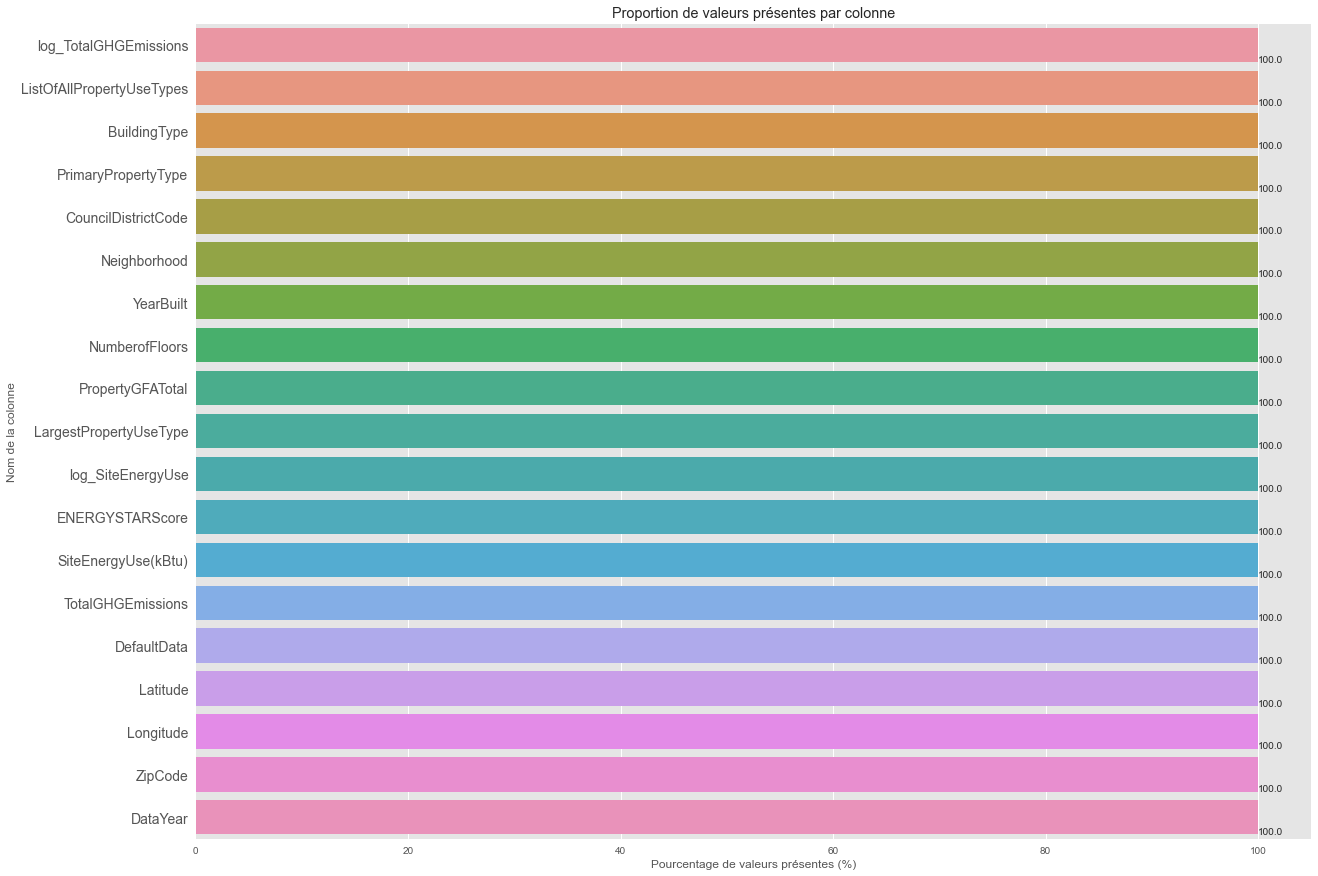

In [8]:
missing_presence(df, figsize=(20, 15))

In [9]:
def select_col_by_type(df, col_type):
    var_object = []
    for col in df.select_dtypes(col_type):
        var_object.append(col)
    return var_object

In [10]:
fast_dataset_info(df)

Le jeu de données contient 1677 lignes et 19 colonnes,  0 lignes dupliquées
Taux de valeurs manquantes :  
log_TotalGHGEmissions        0.0
ListOfAllPropertyUseTypes    0.0
BuildingType                 0.0
PrimaryPropertyType          0.0
CouncilDistrictCode          0.0
Neighborhood                 0.0
YearBuilt                    0.0
NumberofFloors               0.0
PropertyGFATotal             0.0
LargestPropertyUseType       0.0
log_SiteEnergyUse            0.0
ENERGYSTARScore              0.0
SiteEnergyUse(kBtu)          0.0
TotalGHGEmissions            0.0
DefaultData                  0.0
Latitude                     0.0
Longitude                    0.0
ZipCode                      0.0
DataYear                     0.0
dtype: float64 valeurs vides


In [11]:
df["DataYear"] = df.DataYear.astype(object)
df["ZipCode"] = df.ZipCode.astype(object)
df["CouncilDistrictCode"] = df.CouncilDistrictCode.astype(object)

In [12]:
object_var = select_col_by_type(df, 'object')
float_var = select_col_by_type(df, 'float')
int_var = select_col_by_type(df, 'int')
num_var = float_var + int_var

In [13]:
num_var

['NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Latitude',
 'Longitude',
 'log_SiteEnergyUse',
 'log_TotalGHGEmissions',
 'YearBuilt']

In [14]:
targets = ["SiteEnergyUse(kBtu)", "TotalGHGEmissions", "log_TotalGHGEmissions", "log_SiteEnergyUse"]
features = df.columns.to_list()

In [15]:
features

['DataYear',
 'BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'YearBuilt',
 'NumberofFloors',
 'PropertyGFATotal',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'DefaultData',
 'Latitude',
 'Longitude',
 'ZipCode',
 'log_SiteEnergyUse',
 'log_TotalGHGEmissions']

In [16]:
features_without_energy = ['DataYear', 'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
                        'Neighborhood', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal',
                        'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SiteEnergyUse(kBtu)', 
                           'DefaultData', 'Latitude', 'Longitude', 'ZipCode']

In [17]:
features_with_energy = ['DataYear', 'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
                        'Neighborhood', 'YearBuilt', 'NumberofFloors', 'PropertyGFATotal',
                        'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 
                           'DefaultData', 'Latitude', 'Longitude', 'ZipCode', 'ENERGYSTARScore']

In [18]:
def handle_target(target, energy=True):
    if energy == False:
        features1 = features_without_energy
    else:
        features1 = features
    y = df[target]
    setA = set(features1)
    setB = set(targets)
    features_for_pred = setA.difference(setB)
    X = df[features_for_pred]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [19]:
df = df[df['log_TotalGHGEmissions']>0]
df = df[df['TotalGHGEmissions']>0]
df = df[df['SiteEnergyUse(kBtu)']>0]
df = df[df['log_SiteEnergyUse']>0]
df = df[df['PropertyGFATotal']>0]
df = df[df['ENERGYSTARScore']>0]
df = df[df['YearBuilt']>0]


In [20]:
#df1 = df.replace(to_replace = np.nan, value = -999) 

# Prédiction

## Fonctions de prédiction 

### Fonctions de prédiction hyperparametres par défaut

In [21]:
def modeliser(targets, energy=True):
    for target in targets:
        print("----------------------  " +
              str.upper(target) + "  ----------------------")
        # handle_target(target)

        if energy == False:
            features1 = features_without_energy
        else:
            features1 = features_with_energy

        y = df[target]
        setA = set(features1)
        setB = set(targets)
        features_for_pred = setA.difference(setB)
        X = df[features_for_pred]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0)

    # Sépraration des variables selon le type
        numerical_features = make_column_selector(dtype_include=np.number)
        categorical_features = make_column_selector(dtype_exclude=np.number)
        # Transformation des variables numériques
        numerical_pipeline = make_pipeline(SelectKBest(f_regression, k=5),
                                           #SimpleImputer(strategy='constant', fill_value='missing'),
                                           StandardScaler(with_mean=False))
        # Transformation des variables catégorielles
        categorical_pipeline = make_pipeline(#SimpleImputer(strategy='constant', fill_value='missing'),
                                             OneHotEncoder(handle_unknown="ignore"), 
            SelectKBest(f_regression, k=5)
        )
        # Preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('categorical', categorical_pipeline, categorical_features),
                ('numeric', numerical_pipeline, numerical_features),
            ]
        )
        preprocessor.fit(X_train, y_train)
        global LinearRegression, Ridge, Lasso, DecisionTree, RandomForest, AdaBoost, XGBRegressor, ExtraTrees
        global GradientBoosting, DummyRegressor

        DummyRegressor = Pipeline(
            steps=[('preprocessor', preprocessor), ('regressor', DummyRegressor())])

        LinearRegression = Pipeline(
            steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

        Ridge = Pipeline(
            steps=[('preprocessor', preprocessor), ('regressor', Ridge(random_state=0))])

        Lasso = Pipeline(
            steps=[('preprocessor', preprocessor), ('regressor', Lasso(random_state=0))])

        DecisionTree = Pipeline(steps=[(
            'preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=0))])

        ExtraTrees = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', ExtraTreesRegressor(random_state=0))])

        RandomForest = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('regressor', RandomForestRegressor(random_state=0))])
        GradientBoosting = Pipeline(steps=[('preprocessor', preprocessor),
                                           ('regressor', GradientBoostingRegressor(random_state=0))])

        AdaBoost = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', AdaBoostRegressor(random_state=0))])

        XGBRegressor = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('regressor', XGBRegressor(random_state=0))])

        dict_of_models = {

            'DummyRegressor': DummyRegressor,
            'LinearRegression': LinearRegression,
            'Ridge': Ridge,
            'Lasso': Lasso,
            'DecisionTree': DecisionTree,
            'ExtraTrees': ExtraTrees,
            'RandomForest': RandomForest,
            'GradientBoosting': GradientBoosting,
            'AdaBoost': AdaBoost,
            'XGBRegressor': XGBRegressor
        }

        # Modelisation
        model_names = []
        score_models = []
        for name, model in dict_of_models.items():
            model_names.append(name)
            if 'log' in target:
                #print("Log trouvé")
                score_model = evaluation(
                    model, X_train, X_test, y_train, y_test, target_log=True)
                score_models.append(score_model)
            else:
                score_model = evaluation(
                    model, X_train, X_test, y_train, y_test, target_log=False)
                score_models.append(score_model)

        error_data = pd.DataFrame(score_models, columns=[
                                  'RMSE', 'SCORE_R2'], index=model_names)
        data = error_data
        data['Estimator'] = data.index
        print(data.sort_values(by=['RMSE']))
        plt.figure(figsize=(14, 5))
        ax = sns.barplot(x="Estimator", y="RMSE",
                         data=data.sort_values(by=['RMSE']))
        for bar in ax.patches:
            ax.annotate(format(bar.get_height(), '.0f'),
                        (bar.get_x() + bar.get_width() / 2,
                         bar.get_height()), ha='center', va='center',
                        size=12, xytext=(0, 8),
                        textcoords='offset points')
        return data['RMSE'].idxmin()

### Fonctions d'optimisation avec RandomSearchCV

In [22]:
############################ Optimisation SiteEnergyUse ########################################

def optimiser_random(targets, parameter, energy = True):
    for target in targets:
        print("----------------------  " + str.upper(target) + "  ----------------------")
        # handle_target(target)
        if energy == False:
            features1 = features_without_energy
        else:
            features1 = features

        y = df[target]
        setA = set(features1)
        setB = set(targets)
        features_for_pred = setA.difference(setB)
        X = df[features_for_pred]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0)

        dict_of_models = {
                          'DecisionTree': {"estim": DecisionTree, 'param': param_grid_tree}
                          }
        for dict_name, dict_model in dict_of_models.items():
            for name, model in dict_model.items():
                if name == 'param':
                    parameter = model
                    #print(parameter)
                else:
                    estimator = model
                    # print(estimator)
            best_model = randomise_search_cv_func(estimator, parameter, X_train, X_test, y_train, y_test)
        return best_model
            
            
            
            
            
########################## Optimisation TotalGHGEmissions ######################################



def optimiser_gradient(targets, parameter, energy = True):
    for target in targets:
        print("----------------------  " + str.upper(target) + "  ----------------------")
        # handle_target(target)
        if energy == False:
            features1 = features_without_energy
        else:
            features1 = features_with_energy

        y = df[target]
        setA = set(features1)
        setB = set(targets)
        features_for_pred = setA.difference(setB)
        X = df[features_for_pred]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=0)

        dict_of_models = {
                           'GradientBoosting': {"estim" : GradientBoosting, 'param' :param_grid_GBM}
                          }
        for dict_name, dict_model in dict_of_models.items():
            for name, model in dict_model.items():
                if name == 'param':
                    parameter = model
                    #print(parameter)
                else:
                    estimator = model
                    # print(estimator)
            best_model = randomise_search_cv_func(estimator, parameter, X_train, X_test, y_train, y_test)
        return best_model
            

# Prédictions des targets 

## Prédiction de la consommation totale d’énergie (SiteEnergyUse(kBtu))

In [24]:
df["SiteEnergyUse(kBtu)"].describe()

count    1.659000e+03
mean     3.440617e+06
std      3.253200e+06
min      1.680890e+04
25%      1.262246e+06
50%      2.551022e+06
75%      4.339392e+06
max      1.527249e+07
Name: SiteEnergyUse(kBtu), dtype: float64

### SiteEnergyUse(kBtu) non loggé

----------------------  SITEENERGYUSE(KBTU)  ----------------------
                          RMSE  SCORE_R2         Estimator
GradientBoosting  2.608915e+06  0.400280  GradientBoosting
RandomForest      2.640812e+06  0.385525      RandomForest
XGBRegressor      2.686626e+06  0.364020      XGBRegressor
ExtraTrees        2.749837e+06  0.333742        ExtraTrees
Ridge             2.799768e+06  0.309326             Ridge
LinearRegression  2.804105e+06  0.307185  LinearRegression
Lasso             2.804106e+06  0.307184             Lasso
AdaBoost          2.981926e+06  0.216530          AdaBoost
DummyRegressor    3.368886e+06 -0.000004    DummyRegressor
DecisionTree      3.873200e+06 -0.321809      DecisionTree


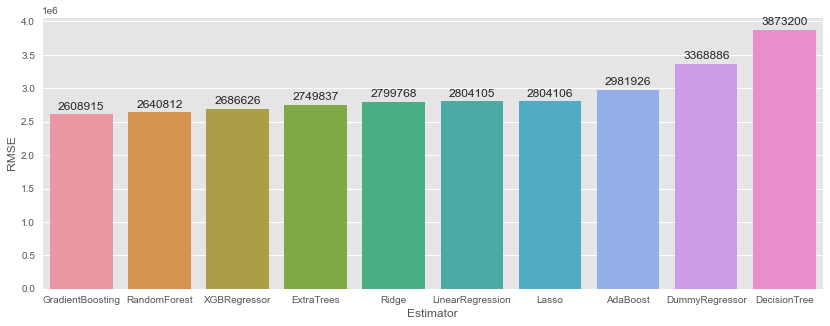

In [26]:
target = ["SiteEnergyUse(kBtu)"]
energy1 = modeliser(target)

In [58]:
perc1= 2608915/15272490
perc1

0.1708244693563394

### SiteEnergyUse(kBtu) loggé 

In [28]:
df["log_SiteEnergyUse"].describe()

count    1659.000000
mean       15.044756
std         1.077028
min        13.161213
25%        14.264925
50%        14.752005
75%        15.731083
max        18.322071
Name: log_SiteEnergyUse, dtype: float64

----------------------  LOG_SITEENERGYUSE  ----------------------
                          RMSE  SCORE_R2         Estimator
GradientBoosting  7.274596e+06  0.456471  GradientBoosting
RandomForest      7.710273e+06  0.389418      RandomForest
AdaBoost          7.893704e+06  0.360020          AdaBoost
XGBRegressor      8.060465e+06  0.332694      XGBRegressor
ExtraTrees        8.269805e+06  0.297583        ExtraTrees
LinearRegression  9.080151e+06  0.153180  LinearRegression
Ridge             9.082163e+06  0.152805             Ridge
DecisionTree      9.520384e+06  0.069077      DecisionTree
DummyRegressor    1.039157e+07 -0.109091    DummyRegressor
Lasso             1.039157e+07 -0.109091             Lasso


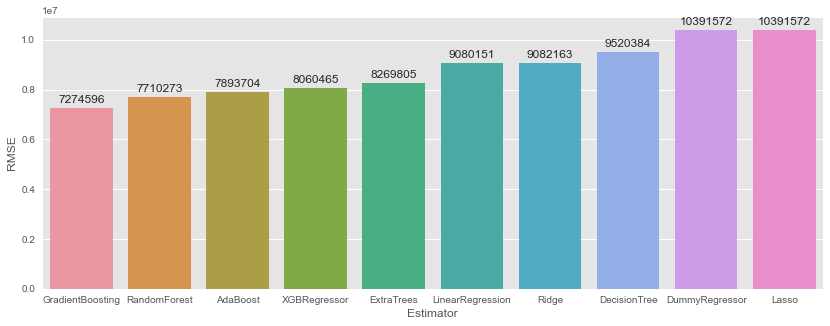

In [29]:
target = ["log_SiteEnergyUse"]
energy2 = modeliser(target)

#### Choix du meilleur modèle à optimiser pour la consommation totale d'énergie

In [31]:
#Choix du modèle à optimiser
print(energy1)

GradientBoosting


In [32]:
energy_best_algo = GradientBoosting

## Prédiction des émissions de CO2 (TotalGHGEmissions)

In [33]:
df["TotalGHGEmissions"].describe()

count    1659.000000
mean       68.724913
std        70.217870
min         0.120000
25%        20.380000
50%        49.580000
75%        86.660000
max       325.940000
Name: TotalGHGEmissions, dtype: float64

### TotalGHGEmissions non loggé avec ENERGYSTARScore

----------------------  TOTALGHGEMISSIONS  ----------------------
                       RMSE  SCORE_R2         Estimator
GradientBoosting  70.335825  0.154266  GradientBoosting
RandomForest      70.530863  0.149569      RandomForest
AdaBoost          72.162431  0.109769          AdaBoost
LinearRegression  72.179392  0.109350  LinearRegression
Ridge             72.183695  0.109244             Ridge
Lasso             72.529016  0.100701             Lasso
XGBRegressor      73.379696  0.079482      XGBRegressor
ExtraTrees        73.902588  0.066316        ExtraTrees
DummyRegressor    76.749509 -0.007005    DummyRegressor
DecisionTree      89.237869 -0.361378      DecisionTree


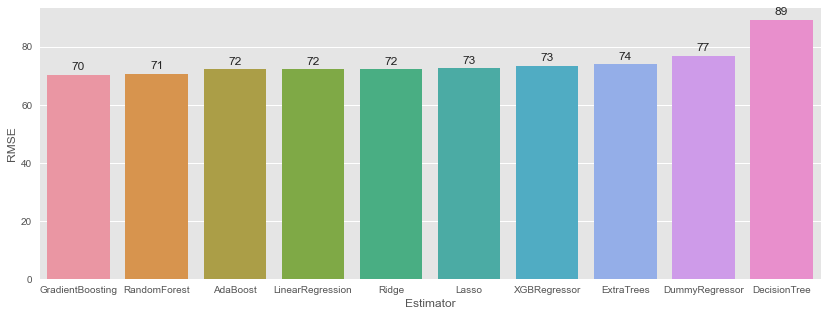

In [35]:
target = ["TotalGHGEmissions"]
emissions1 = modeliser(target)

### TotalGHGEmissions non loggé sans ENERGYSTARScore

In [62]:
df['TotalGHGEmissions'].describe()

count    1659.000000
mean       68.724913
std        70.217870
min         0.120000
25%        20.380000
50%        49.580000
75%        86.660000
max       325.940000
Name: TotalGHGEmissions, dtype: float64

----------------------  TOTALGHGEMISSIONS  ----------------------
                       RMSE  SCORE_R2         Estimator
GradientBoosting  54.348147  0.495048  GradientBoosting
AdaBoost          55.344036  0.476373          AdaBoost
RandomForest      55.737817  0.468895      RandomForest
ExtraTrees        57.349954  0.437728        ExtraTrees
XGBRegressor      59.609377  0.392551      XGBRegressor
Lasso             62.887708  0.323898             Lasso
LinearRegression  63.243144  0.316234  LinearRegression
Ridge             63.245250  0.316189             Ridge
DecisionTree      72.284502  0.106755      DecisionTree
DummyRegressor    76.749509 -0.007005    DummyRegressor


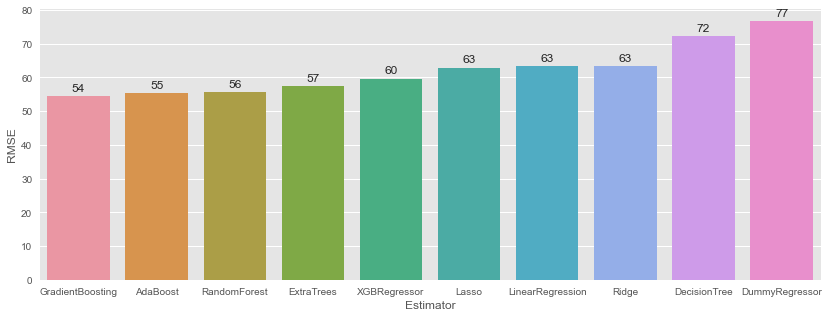

In [37]:
target = ["TotalGHGEmissions"]
emissions2= modeliser(target, False)

### TotalGHGEmissions loggé avec ENERGYSTARScore

----------------------  LOG_TOTALGHGEMISSIONS  ----------------------
                        RMSE  SCORE_R2         Estimator
GradientBoosting  167.959581  0.259435  GradientBoosting
AdaBoost          171.583001  0.227138          AdaBoost
RandomForest      171.624646  0.226763      RandomForest
ExtraTrees        174.344519  0.202060        ExtraTrees
XGBRegressor      178.588282  0.162742      XGBRegressor
LinearRegression  193.971823  0.012287  LinearRegression
Ridge             194.040477  0.011588             Ridge
DummyRegressor    204.560433 -0.098492    DummyRegressor
Lasso             204.560433 -0.098492             Lasso
DecisionTree      266.521086 -0.864733      DecisionTree


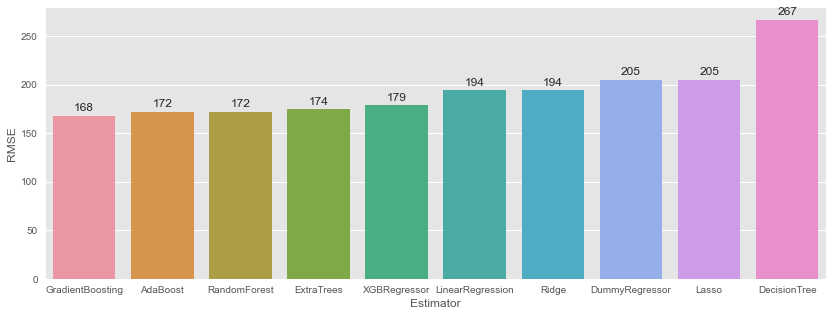

In [39]:
target = ["log_TotalGHGEmissions"]
emissions3 = modeliser(target)

### TotalGHGEmissions  loggé sans ENERGYSTARScore

----------------------  LOG_TOTALGHGEMISSIONS  ----------------------
                        RMSE  SCORE_R2         Estimator
XGBRegressor      135.667132  0.516827      XGBRegressor
ExtraTrees        138.009924  0.499995        ExtraTrees
RandomForest      138.967863  0.493030      RandomForest
GradientBoosting  144.135630  0.454624  GradientBoosting
AdaBoost          149.420986  0.413893          AdaBoost
DecisionTree      167.944409  0.259569      DecisionTree
Ridge             194.632322  0.005549             Ridge
LinearRegression  194.941041  0.002392  LinearRegression
DummyRegressor    204.560433 -0.098492    DummyRegressor
Lasso             204.560433 -0.098492             Lasso


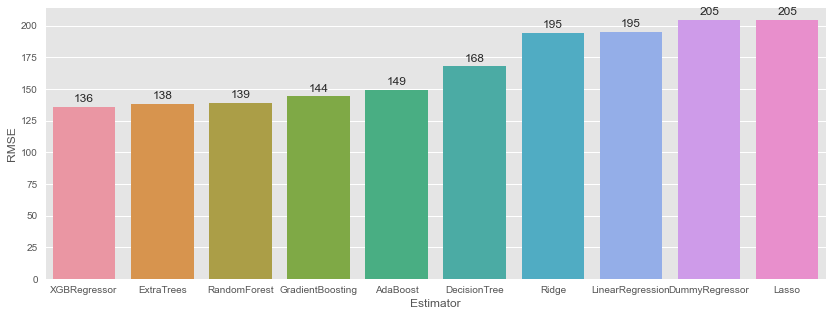

In [41]:
target = ["log_TotalGHGEmissions"]
emissions4 = modeliser(target, False)

In [42]:
print(emissions1)

GradientBoosting


#### Choix du meilleur modèle pour les émissions de CO2

In [43]:
energy_best_algo = GradientBoosting

# Optimisation

## Les hyperparamètres

In [46]:
# les hyperparamètres


#GBM

param_grid_GBM = {'preprocessor__numeric__selectkbest__k': [2,3,4,5],
                  'preprocessor__categorical__selectkbest__k':[2,3,4,5],
                      'regressor__n_estimators': [10, 50, 100, 150, 500],
                      'regressor__max_depth': [2, 3, 4, 5, 6],
                      'regressor__min_samples_split': [2, 3, 4, 5, 6, 10],
                      'regressor__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                      'regressor__subsample' : [0.5, 0.7, 1.0, 2.0]
             }



## Optimisation de la prédiction pour la consommation totale d'énergie avec Gradient Boosting

### Sans mise en exergue de la variance 

----------------------  SITEENERGYUSE(KBTU)  ----------------------
RMSE:  2673372
R2_Score :  0.37


<Figure size 720x576 with 0 Axes>

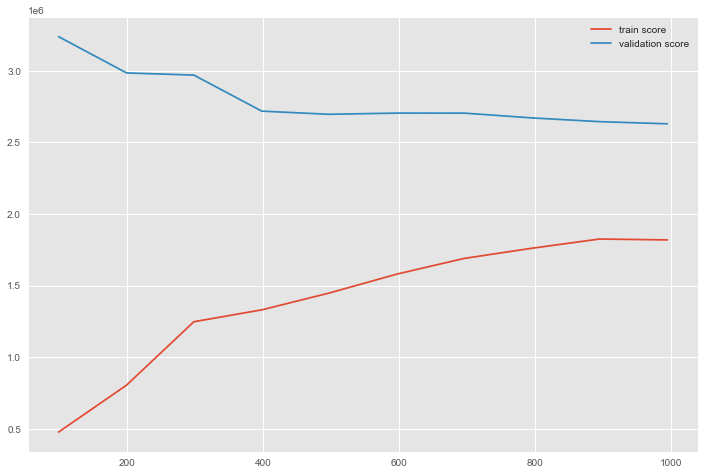

In [47]:
target = ["SiteEnergyUse(kBtu)"]
plt.figure(figsize=(10, 8))
grad_energy = optimiser_gradient(target,param_grid_GBM)

### Avec mise en exergue de la variance

----------------------  SITEENERGYUSE(KBTU)  ----------------------
RMSE:  2698667
R2_Score :  0.36
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__categorical', 'preprocessor__numeric', 'preprocessor__categorical__memory', 'preprocessor__categorical__steps', 'preprocessor__categorical__verbose', 'preprocessor__categorical__onehotencoder', 'preprocessor__categorical__selectkbest', 'preprocessor__categorical__onehotencoder__categories', 'preprocessor__categorical__onehotencoder__drop', 'preprocessor__categorical__onehotencoder__dtype', 'preprocessor__categorical__onehotencoder__handle_unknown', 'preprocessor__categorical__onehotencod

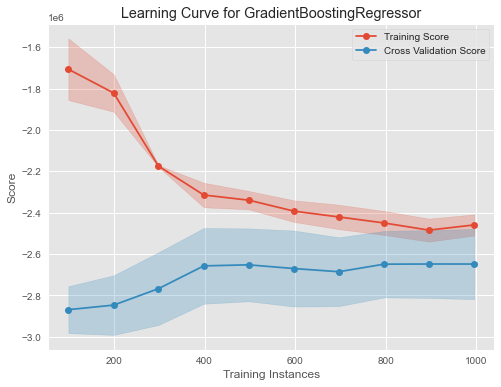

TypeError: cannot unpack non-iterable LearningCurve object

In [55]:
target = ["SiteEnergyUse(kBtu)"]
plt.figure(figsize=(8, 6))
grad_energy = optimiser_gradient(target,param_grid_GBM)

## Optimisation de la prédiction pour les émissions de CO2 

### Sans mise en exergue 

----------------------  TOTALGHGEMISSIONS  ----------------------
RMSE:  55
R2_Score :  0.48


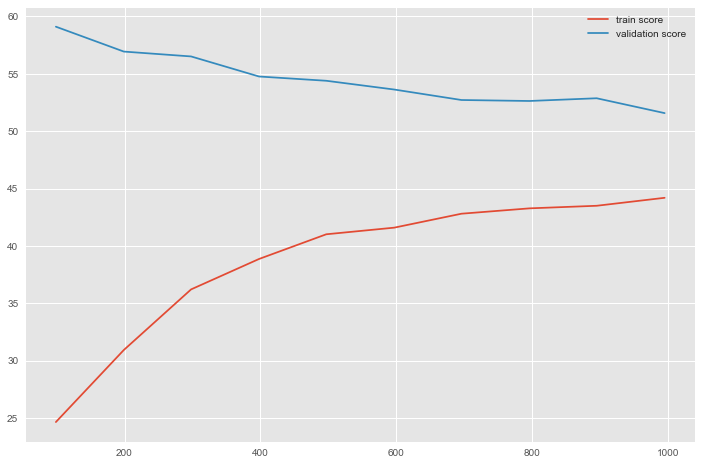

In [51]:
target = ["TotalGHGEmissions"]
gb_model_emissions1 = optimiser_gradient(target,param_grid_GBM, False)

### Avec mise en exergue 

----------------------  TOTALGHGEMISSIONS  ----------------------
RMSE:  56
R2_Score :  0.47
dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'memory', 'steps', 'verbose', 'preprocessor', 'regressor', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__categorical', 'preprocessor__numeric', 'preprocessor__categorical__memory', 'preprocessor__categorical__steps', 'preprocessor__categorical__verbose', 'preprocessor__categorical__onehotencoder', 'preprocessor__categorical__selectkbest', 'preprocessor__categorical__onehotencoder__categories', 'preprocessor__categorical__onehotencoder__drop', 'preprocessor__categorical__onehotencoder__dtype', 'preprocessor__categorical__onehotencoder__handle_unknown', 'preprocessor__categorical__onehotencoder__spa

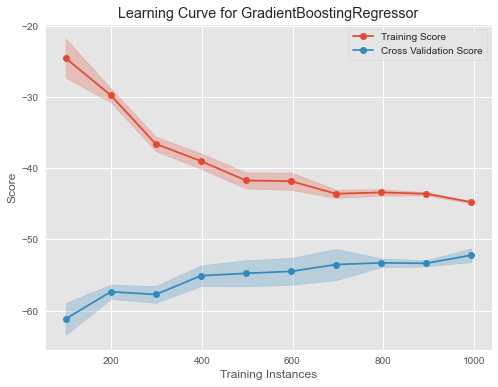

TypeError: cannot unpack non-iterable LearningCurve object

In [56]:
target = ["TotalGHGEmissions"]
plt.figure(figsize=(8, 6))
gb_model_emissions2 = optimiser_gradient(target,param_grid_GBM, False)